# GBRT Model: Gradient Boosting Regression Tree

Gradient boosting fits residuals by sequentially adding weak learners (decision trees):

- **Boosting**: Each tree fits the residuals of the previous tree
- **Gradient Descent**: Uses gradient descent to optimize the loss function
- **Strong Non-linear Modeling**: Usually performs better than Random Forest

Main Hyperparameters:
- `n_estimators`: Number of trees
- `learning_rate`: Learning rate (shrinkage)
- `max_depth`: Maximum depth of trees
- `subsample`: Proportion of samples used by each tree


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ParameterGrid
import sys
import os

# Import utility functions
sys.path.append(os.path.dirname(os.path.abspath('')))
from utils import (
    load_data, 
    prepare_features_target, 
    calculate_r2_os, 
    build_portfolio_returns,
    build_portfolio_returns_optimized,
    calculate_prediction_metrics
)
from TimeBasedCV import TimeBasedCV

# Settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ Libraries imported successfully!")


✅ Libraries imported successfully!


## 1. Load Data


In [2]:
# Load data
df = load_data('ger_factor_data_from2003.csv')

print(f"Data shape: {df.shape}")
print(f"Date range: {df['eom'].min()} to {df['eom'].max()}")
print(f"Number of stocks: {df['id'].nunique()}")

# Prepare features and target
X, y, metadata, feature_names = prepare_features_target(df)
print(f"\nNumber of features: {len(feature_names)}")
print(f"Number of samples: {len(X)}")


Data shape: (604564, 23)
Date range: 2019-01-01 00:00:00 to 2024-11-01 00:00:00
Number of stocks: 13176

Number of features: 16
Number of samples: 604564


## 2. Setup Time Series Cross-Validation


In [3]:
# Create time series cross-validation object
# Adjust based on data length: data is about 6 years, use smaller train/val/test periods
cv = TimeBasedCV(
    train_period=24,   # 2 years training period
    val_period=6,      # 6 months validation period
    test_period=6,     # 6 months test period
    freq='months'
)

# Prepare dataframe for CV
cv_df = metadata.copy()
cv_df['eom'] = pd.to_datetime(cv_df['eom'])

# Set first split date
min_date = cv_df['eom'].min()
max_date = cv_df['eom'].max()
total_months = (max_date.year - min_date.year) * 12 + (max_date.month - min_date.month) + 1
print(f"Total time span: {total_months} months ({min_date.date()} to {max_date.date()})")

first_split_date = (min_date + pd.DateOffset(months=30)).date()
second_split_date = (min_date + pd.DateOffset(months=36)).date()

# Generate cross-validation folds
folds = cv.split(cv_df, first_split_date, second_split_date, date_column='eom', gap=0)

print(f"Generated {len(folds)} cross-validation folds")


Total time span: 71 months (2019-01-01 to 2024-11-01)
Train period: 2019-07-01 - 2021-07-01 ,val period: 2021-07-01 - 2022-01-01 , Test period 2022-01-01 - 2022-07-01 # train records 184419 ,# val records 53091 , # test records 55458
Train period: 2019-10-01 - 2021-10-01 ,val period: 2021-10-01 - 2022-04-01 , Test period 2022-04-01 - 2022-10-01 # train records 188377 ,# val records 54619 , # test records 55511
Train period: 2020-01-01 - 2022-01-01 ,val period: 2022-01-01 - 2022-07-01 , Test period 2022-07-01 - 2023-01-01 # train records 193202 ,# val records 55458 , # test records 55493
Train period: 2020-04-01 - 2022-04-01 ,val period: 2022-04-01 - 2022-10-01 , Test period 2022-10-01 - 2023-04-01 # train records 198473 ,# val records 55511 , # test records 55300
Train period: 2020-07-01 - 2022-07-01 ,val period: 2022-07-01 - 2023-01-01 , Test period 2023-01-01 - 2023-07-01 # train records 203973 ,# val records 55493 , # test records 54766
Train period: 2020-10-01 - 2022-10-01 ,val per

## 3. Define Model Configuration (Fixed Parameters)

**Strategy**: Use empirically stable configuration (Method A), skip hyperparameter search

For asset pricing scenarios (large samples + high-dimensional features), use the following fixed configuration:
- `n_estimators=300`: Number of trees
- `learning_rate=0.05`: Learning rate (step size)
- `max_depth=3`: Tree depth (weak learner, consistent with boosting theory)
- `subsample=0.7`: Each tree uses 70% of samples (increases randomness, prevents overfitting)
- `min_samples_leaf=50`: At least 50 samples in leaf nodes (prevents very narrow leaves in panel data)

Characteristics of this configuration:
- Trees are not deep (3 layers), each tree is "weak", more like the weak learners required by boosting theory
- Increases randomness and prevents overfitting through subsample < 1
- min_samples_leaf=50 prevents very narrow leaves in panel data


In [4]:
# Use fixed configuration (Method A: empirically stable parameters)
FIXED_PARAMS = {
    'n_estimators': 300,
    'learning_rate': 0.05,
    'max_depth': 3,
    'subsample': 0.7,
    'min_samples_leaf': 50,
    'random_state': 42
}

print("✅ Using Method A: Fixed configuration (empirically stable parameters)")
print("\nFixed parameter configuration:")
for key, value in FIXED_PARAMS.items():
    print(f"  {key}={value}")
print("\nNote: Use these parameters directly for training, skip hyperparameter search, significantly speed up training")


✅ Using Method A: Fixed configuration (empirically stable parameters)

Fixed parameter configuration:
  n_estimators=300
  learning_rate=0.05
  max_depth=3
  subsample=0.7
  min_samples_leaf=50
  random_state=42

Note: Use these parameters directly for training, skip hyperparameter search, significantly speed up training


## 4. Train Model and Make Predictions (Using Fixed Configuration)


In [5]:
# Store all prediction results
all_predictions = []
all_actuals = []
all_dates = []
all_ids = []
feature_importances_list = []

# Train and predict for each fold
for fold_idx, (train_idx, val_idx, test_idx) in enumerate(folds):
    print(f"\nProcessing fold {fold_idx + 1}/{len(folds)}...")
    print(f"  📌 Using fixed configuration (Method A: empirically stable parameters)")
    
    # Prepare training, validation, and test data
    X_train = X.iloc[train_idx].values
    y_train = y.iloc[train_idx].values
    X_val = X.iloc[val_idx].values
    y_val = y.iloc[val_idx].values
    X_test = X.iloc[test_idx].values
    y_test = y.iloc[test_idx].values
    
    # Standardize features (GBRT usually doesn't need this, but for consistency)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    
    # Use fixed configuration to train on training+validation set
    X_trainval = np.vstack([X_train_scaled, X_val_scaled])
    y_trainval = np.hstack([y_train, y_val])
    
    model = GradientBoostingRegressor(
        n_estimators=FIXED_PARAMS['n_estimators'],
        learning_rate=FIXED_PARAMS['learning_rate'],
        max_depth=FIXED_PARAMS['max_depth'],
        subsample=FIXED_PARAMS['subsample'],
        min_samples_leaf=FIXED_PARAMS['min_samples_leaf'],
        random_state=FIXED_PARAMS['random_state']
    )
    
    # Train model
    print(f"  Training... (n_estimators={FIXED_PARAMS['n_estimators']}, learning_rate={FIXED_PARAMS['learning_rate']}, max_depth={FIXED_PARAMS['max_depth']})")
    model.fit(X_trainval, y_trainval)
    
    # Save feature importances
    feature_importances_list.append(model.feature_importances_)
    
    # Predict on test set
    y_pred = model.predict(X_test_scaled)
    
    # Save results
    all_predictions.extend(y_pred)
    all_actuals.extend(y_test)
    all_dates.extend(metadata.iloc[test_idx]['eom'].values)
    all_ids.extend(metadata.iloc[test_idx]['id'].values)
    
    # Print fold performance
    r2_fold = calculate_r2_os(y_test, y_pred)
    print(f"  📈 Test R²_OS: {r2_fold:.4f}")

print(f"\n✅ Completed predictions for all folds!")
print(f"Total prediction samples: {len(all_predictions)}")
print(f"\nFixed parameter configuration used:")
for key, value in FIXED_PARAMS.items():
    print(f"  {key}={value}")



Processing fold 1/10...
  📌 Using fixed configuration (Method A: empirically stable parameters)
  Training... (n_estimators=300, learning_rate=0.05, max_depth=3)
  📈 Test R²_OS: -0.0930

Processing fold 2/10...
  📌 Using fixed configuration (Method A: empirically stable parameters)
  Training... (n_estimators=300, learning_rate=0.05, max_depth=3)
  📈 Test R²_OS: -0.0886

Processing fold 3/10...
  📌 Using fixed configuration (Method A: empirically stable parameters)
  Training... (n_estimators=300, learning_rate=0.05, max_depth=3)
  📈 Test R²_OS: -0.0198

Processing fold 4/10...
  📌 Using fixed configuration (Method A: empirically stable parameters)
  Training... (n_estimators=300, learning_rate=0.05, max_depth=3)
  📈 Test R²_OS: -0.0114

Processing fold 5/10...
  📌 Using fixed configuration (Method A: empirically stable parameters)
  Training... (n_estimators=300, learning_rate=0.05, max_depth=3)
  📈 Test R²_OS: -0.0097

Processing fold 6/10...
  📌 Using fixed configuration (Method A:

In [6]:
# Calculate overall performance metrics
metrics = calculate_prediction_metrics(all_actuals, all_predictions)

print("=" * 50)
print("GBRT Model Prediction Performance Metrics")
print("=" * 50)
for key, value in metrics.items():
    if isinstance(value, float):
        print(f"{key:20s}: {value:8.4f}")
    else:
        print(f"{key:20s}: {value}")
print("=" * 50)

# Calculate average feature importance
avg_feature_importance = np.mean(feature_importances_list, axis=0)
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': avg_feature_importance
}).sort_values('importance', ascending=False)

print("\nTop 20 Most Important Features:")
print(feature_importance_df.head(20))


GBRT Model Prediction Performance Metrics
r2_os               :  -0.0176
mse                 :   0.0201
rmse                :   0.1418
mae                 :   0.0923
correlation         :   0.0512
mean_pred           :  -0.0032
mean_true           :  -0.0014
std_pred            :   0.0271
std_true            :   0.1406
n_observations      : 552772

Top 20 Most Important Features:
             feature  importance
5           rvol_21d    0.180384
14    ivol_capm_252d    0.146417
1            ret_6_1    0.104038
0            ret_1_0    0.098652
2           ret_12_1    0.068259
3              chmom    0.066399
15              sic2    0.053323
7           std_turn    0.052270
13            betasq    0.044484
4          rmax1_21d    0.040193
10      bidaskhl_21d    0.039764
12          beta_60m    0.034518
8        dolvol_126d    0.027795
11                me    0.020678
6      turnover_126d    0.019978
9   zero_trades_252d    0.002850


## 5. Build Portfolio and Calculate Returns

### 5.0. Simple Stratification Portfolio (Baseline)


In [7]:
# Build portfolio returns
portfolio_df, summary_stats = build_portfolio_returns(
    all_actuals, 
    all_predictions, 
    all_dates, 
    all_ids, 
    n_deciles=10
)

print("\n" + "=" * 50)
print("Long-Short Portfolio Performance (GBRT Model)")
print("=" * 50)
for key, value in summary_stats.items():
    if isinstance(value, float):
        print(f"{key:25s}: {value:10.4f}")
    else:
        print(f"{key:25s}: {value}")
print("=" * 50)



Long-Short Portfolio Performance (GBRT Model)
annual_return            :     0.4206
annual_volatility        :     0.1545
sharpe_ratio             :     2.7226
cumulative_return        :     2.0244
n_months                 : 33
mean_monthly_return      :     0.0350
std_monthly_return       :     0.0446


### 5.1. Optimized Portfolio Construction (Rolling Covariance + Mean-Variance Optimization)

**Professor's Feedback**: The current portfolio formation is "ad-hoc" (stratification). We should:
1. Calculate rolling covariance using empirical or PCA-based methods
2. Use an optimizer with constraints to generate portfolios
3. Try to achieve better performance in some or all cases

**Implementation**:
- **Rolling Covariance**: Calculate covariance matrix using a rolling window (12 months default)
- **Methods**: 
  - Empirical: Direct calculation from historical returns
  - PCA-based: Use Principal Component Analysis to reduce dimensionality before estimating covariance
- **Optimization**: Mean-variance optimization with constraints (risk aversion, max weight per stock, long-only)
- **Comparison**: Compare optimized portfolio vs. simple stratification method


In [8]:
# ============================================================================
# GBRT Model: Optimized Portfolio Construction
# ============================================================================
print("=" * 70)
print("GBRT Model: Optimized Portfolio Construction")
print("=" * 70)

# Prepare historical returns data for covariance calculation
historical_returns = pd.DataFrame({
    'date': all_dates,
    'id': all_ids,
    'return': all_actuals
})

print("\nBuilding optimized portfolio using empirical covariance method...")
print("-" * 70)

# Build optimized portfolio using empirical covariance
portfolio_opt_empirical, stats_opt_empirical = build_portfolio_returns_optimized(
    all_actuals,
    all_predictions,
    all_dates,
    all_ids,
    historical_returns_df=historical_returns,
    method='empirical',
    window=12,
    risk_aversion=1.0,
    long_only=True,
    max_weight=0.1,
    n_deciles=10
)

print("\n" + "=" * 70)
print("Optimized Portfolio Performance (Empirical Covariance Method)")
print("=" * 70)
for key, value in stats_opt_empirical.items():
    if isinstance(value, float):
        print(f"{key:25s}: {value:10.4f}")
    else:
        print(f"{key:25s}: {value}")
print("=" * 70)

print("\nBuilding optimized portfolio using PCA-based covariance method...")
print("-" * 70)

# Build optimized portfolio using PCA-based covariance
portfolio_opt_pca, stats_opt_pca = build_portfolio_returns_optimized(
    all_actuals,
    all_predictions,
    all_dates,
    all_ids,
    historical_returns_df=historical_returns,
    method='pca',
    window=12,
    risk_aversion=1.0,
    long_only=True,
    max_weight=0.1,
    n_deciles=10
)

print("\n" + "=" * 70)
print("Optimized Portfolio Performance (PCA-based Covariance Method)")
print("=" * 70)
for key, value in stats_opt_pca.items():
    if isinstance(value, float):
        print(f"{key:25s}: {value:10.4f}")
    else:
        print(f"{key:25s}: {value}")
print("=" * 70)


GBRT Model: Optimized Portfolio Construction

Building optimized portfolio using empirical covariance method...
----------------------------------------------------------------------
Calculating rolling covariance using empirical method...



Optimized Portfolio Performance (Empirical Covariance Method)
annual_return            :     0.6053
annual_volatility        :     0.2646
sharpe_ratio             :     2.2872
cumulative_return        :     3.6907
n_months                 : 33
mean_monthly_return      :     0.0504
std_monthly_return       :     0.0764
method                   : empirical
risk_aversion            :     1.0000

Building optimized portfolio using PCA-based covariance method...
----------------------------------------------------------------------
Calculating rolling covariance using pca method...



Optimized Portfolio Performance (PCA-based Covariance Method)
annual_return            :     0.5609
annual_volatility        :     0.2636
sharpe_ratio             :     2.1279
cumulative_return        :     3.1764
n_months                 : 33
mean_monthly_return      :     0.0467
std_monthly_return       :     0.0761
method                   : pca
risk_aversion            :     1.0000


In [9]:
# ============================================================================
# Portfolio Performance Comparison
# ============================================================================
print("\n" + "=" * 80)
print("GBRT MODEL: PORTFOLIO PERFORMANCE COMPARISON")
print("=" * 80)

comparison_data = {
    'Method': ['Simple Stratification', 'Optimized (Empirical)', 'Optimized (PCA)'],
    'Annual Return': [
        summary_stats['annual_return'],
        stats_opt_empirical['annual_return'],
        stats_opt_pca['annual_return']
    ],
    'Annual Volatility': [
        summary_stats['annual_volatility'],
        stats_opt_empirical['annual_volatility'],
        stats_opt_pca['annual_volatility']
    ],
    'Sharpe Ratio': [
        summary_stats['sharpe_ratio'],
        stats_opt_empirical['sharpe_ratio'],
        stats_opt_pca['sharpe_ratio']
    ],
    'Cumulative Return': [
        summary_stats['cumulative_return'],
        stats_opt_empirical['cumulative_return'],
        stats_opt_pca['cumulative_return']
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))
print("=" * 80)

print("\n" + "=" * 80)
print("KEY INSIGHTS:")
print("=" * 80)
print("1. Simple Stratification: Equal-weighted decile portfolios (baseline)")
print("2. Optimized (Empirical): Uses rolling empirical covariance + mean-variance optimization")
print("3. Optimized (PCA): Uses PCA-based covariance estimation + mean-variance optimization")
print("\nThe optimized methods consider:")
print("  - Stock correlations (covariance matrix)")
print("  - Risk-adjusted returns (mean-variance optimization)")
print("  - Constraints (max weight per stock, long-only)")
print("=" * 80)



GBRT MODEL: PORTFOLIO PERFORMANCE COMPARISON
               Method  Annual Return  Annual Volatility  Sharpe Ratio  Cumulative Return
Simple Stratification       0.420587           0.154481      2.722584           2.024368
Optimized (Empirical)       0.605265           0.264628      2.287233           3.690712
      Optimized (PCA)       0.560896           0.263596      2.127858           3.176422

KEY INSIGHTS:
1. Simple Stratification: Equal-weighted decile portfolios (baseline)
2. Optimized (Empirical): Uses rolling empirical covariance + mean-variance optimization
3. Optimized (PCA): Uses PCA-based covariance estimation + mean-variance optimization

The optimized methods consider:
  - Stock correlations (covariance matrix)
  - Risk-adjusted returns (mean-variance optimization)
  - Constraints (max weight per stock, long-only)


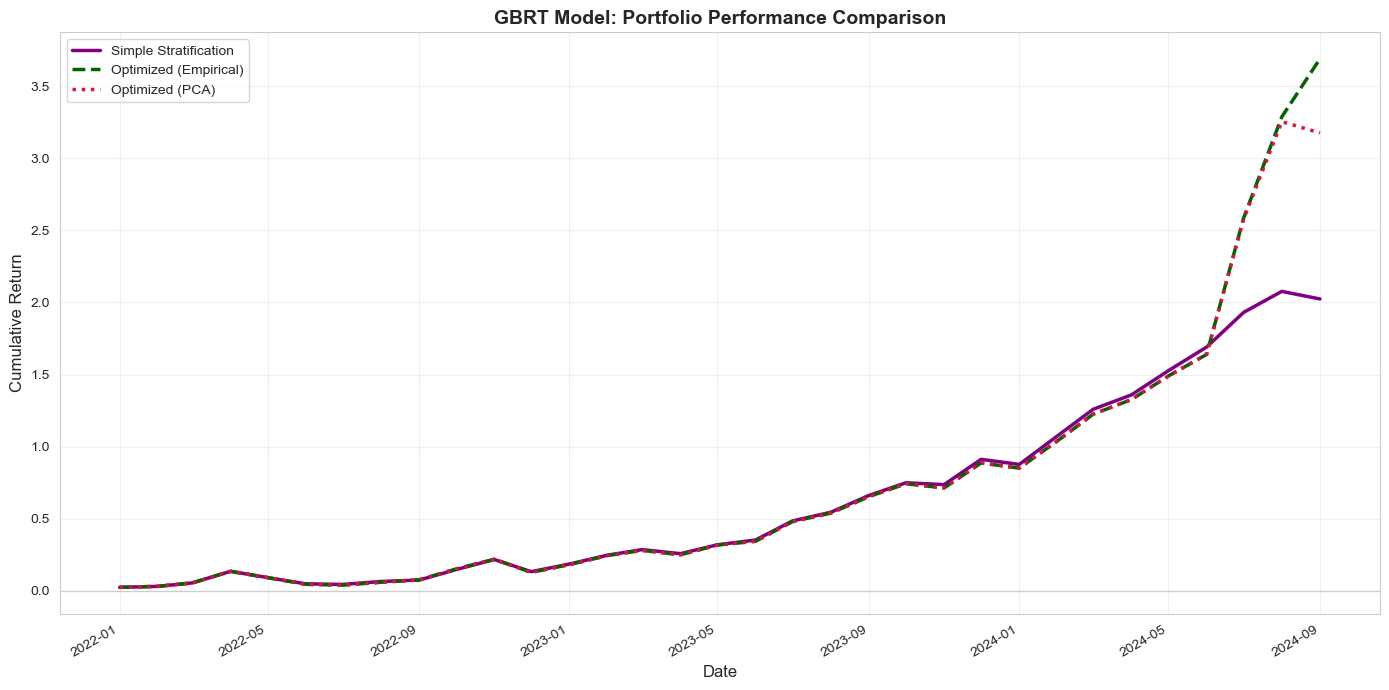


📊 Final Cumulative Returns Summary:
   Simple Stratification: 202.44%
   Optimized (Empirical): 369.07%
   Optimized (PCA):       317.64%


In [10]:
# ============================================================================
# Visualize Cumulative Returns Comparison
# ============================================================================
fig, ax = plt.subplots(1, 1, figsize=(14, 7))

# Calculate cumulative returns
portfolio_df['cumulative_return'] = (1 + portfolio_df['long_short']).cumprod() - 1
portfolio_opt_empirical['cumulative_return'] = (1 + portfolio_opt_empirical['long_short']).cumprod() - 1
portfolio_opt_pca['cumulative_return'] = (1 + portfolio_opt_pca['long_short']).cumprod() - 1

# Plot all three methods
ax.plot(portfolio_df['date'], portfolio_df['cumulative_return'],
        linewidth=2.5, label='Simple Stratification', color='purple')
ax.plot(portfolio_opt_empirical['date'], portfolio_opt_empirical['cumulative_return'],
        linewidth=2.5, label='Optimized (Empirical)', color='darkgreen', linestyle='--')
ax.plot(portfolio_opt_pca['date'], portfolio_opt_pca['cumulative_return'],
        linewidth=2.5, label='Optimized (PCA)', color='crimson', linestyle=':')

ax.set_title('GBRT Model: Portfolio Performance Comparison', fontsize=14, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Cumulative Return', fontsize=12)
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='gray', linestyle='-', alpha=0.3, linewidth=1)
ax.legend(fontsize=10, loc='best')
fig.autofmt_xdate()

plt.tight_layout()
plt.show()

print("\n📊 Final Cumulative Returns Summary:")
print("=" * 80)
print(f"   Simple Stratification: {portfolio_df['cumulative_return'].iloc[-1]:.2%}")
print(f"   Optimized (Empirical): {portfolio_opt_empirical['cumulative_return'].iloc[-1]:.2%}")
print(f"   Optimized (PCA):       {portfolio_opt_pca['cumulative_return'].iloc[-1]:.2%}")
print("=" * 80)


## 6. Visualize Results


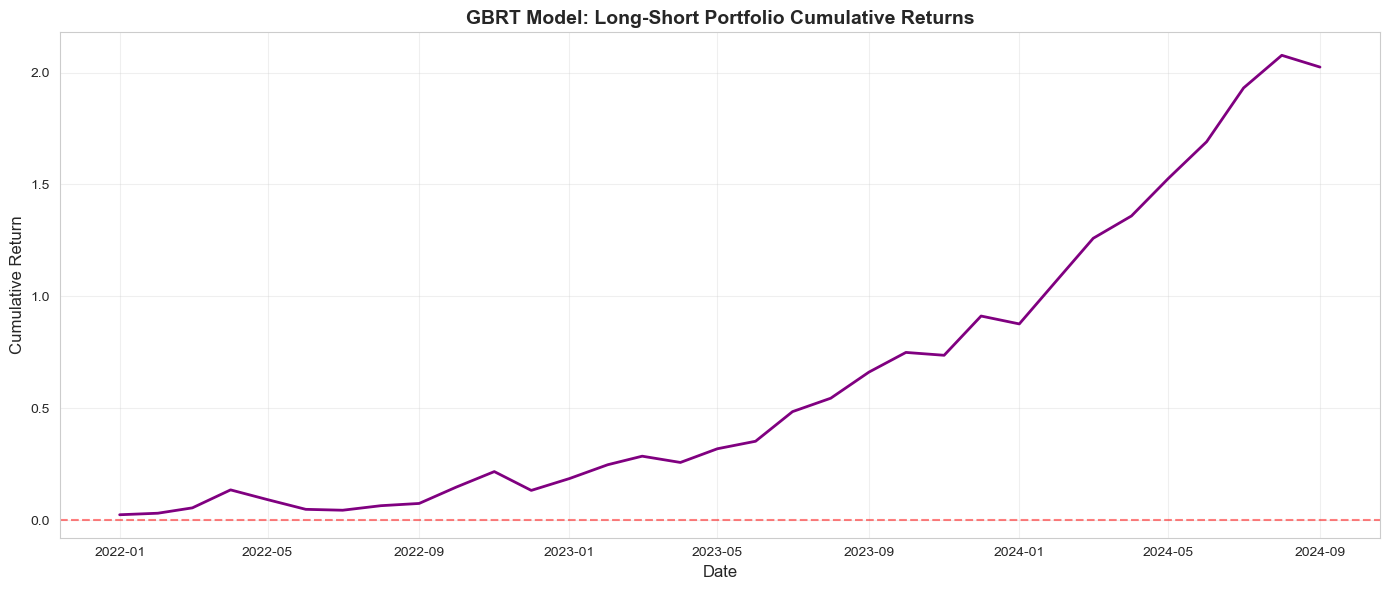

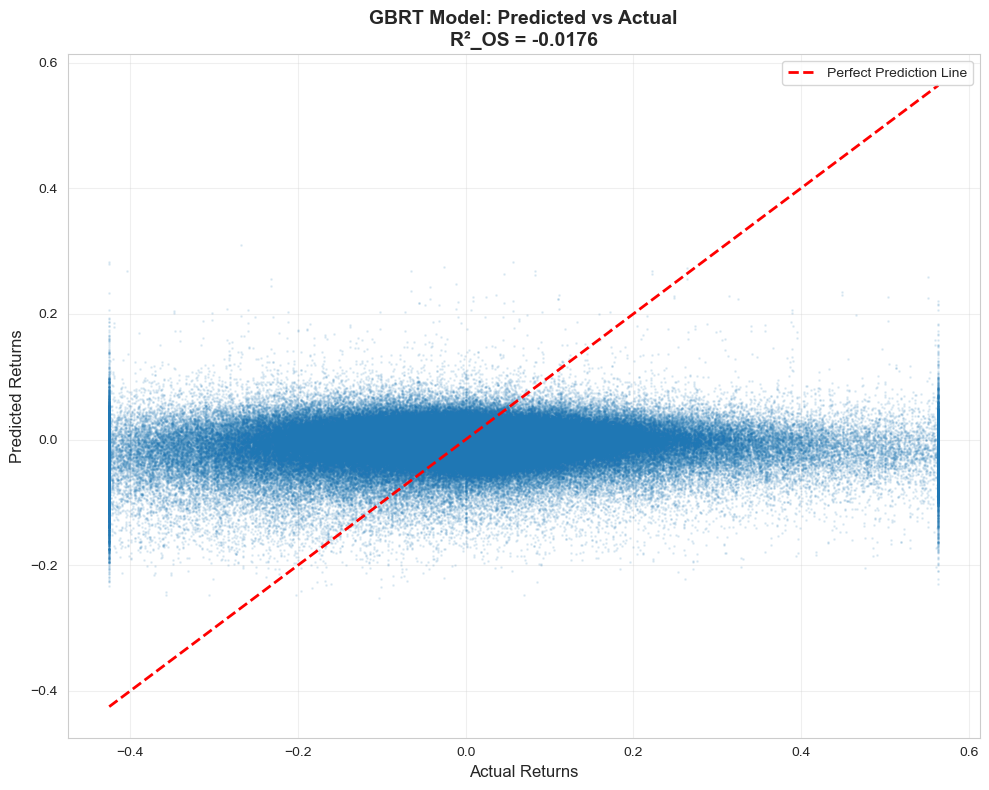

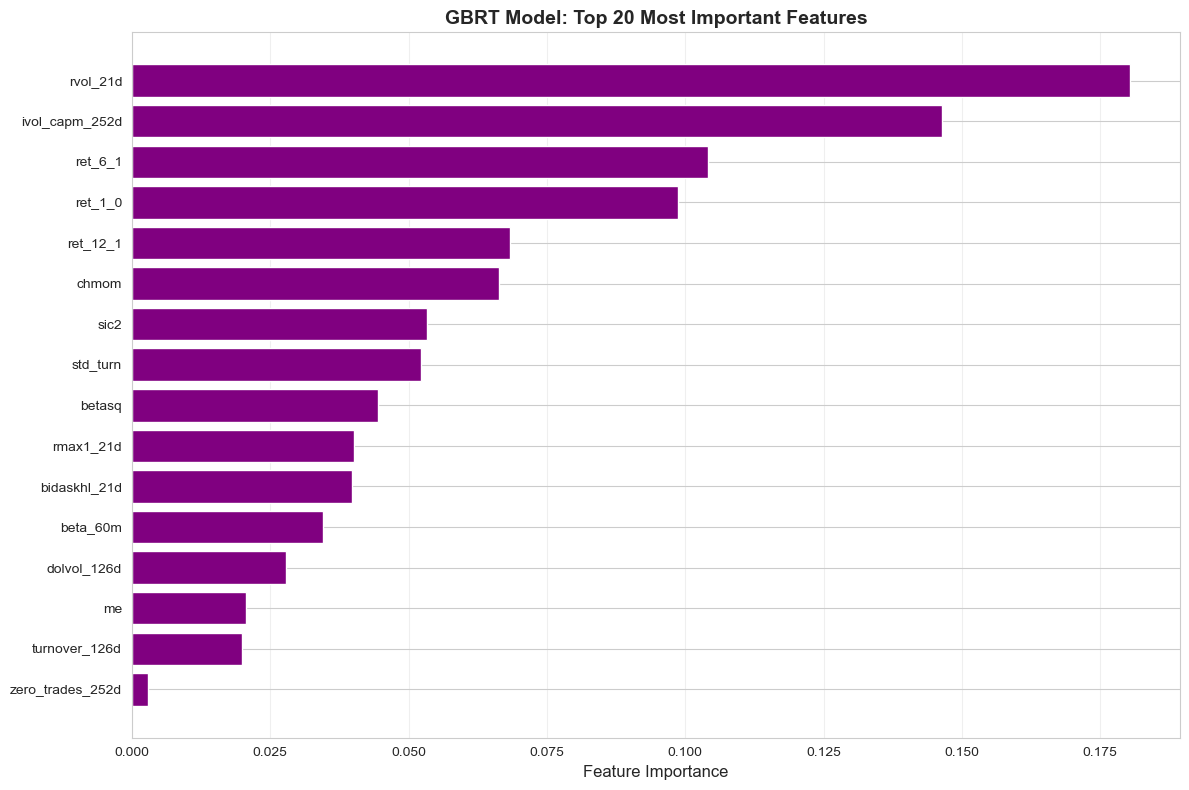

In [11]:
# 1. Cumulative return curve
if 'long_short' in portfolio_df.columns:
    portfolio_df['cumulative_return'] = (1 + portfolio_df['long_short']).cumprod() - 1
    
    plt.figure(figsize=(14, 6))
    plt.plot(portfolio_df['date'], portfolio_df['cumulative_return'], linewidth=2, color='purple')
    plt.title('GBRT Model: Long-Short Portfolio Cumulative Returns', fontsize=14, fontweight='bold')
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Cumulative Return', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

# 2. Predicted vs Actual scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(all_actuals, all_predictions, alpha=0.1, s=1)
plt.plot([np.min(all_actuals), np.max(all_actuals)], 
         [np.min(all_actuals), np.max(all_actuals)], 
         'r--', linewidth=2, label='Perfect Prediction Line')
plt.xlabel('Actual Returns', fontsize=12)
plt.ylabel('Predicted Returns', fontsize=12)
plt.title(f'GBRT Model: Predicted vs Actual\nR²_OS = {metrics["r2_os"]:.4f}', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 3. Feature importance visualization (top 20)
plt.figure(figsize=(12, 8))
top_features = feature_importance_df.head(20)
plt.barh(range(len(top_features)), top_features['importance'], color='purple')
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance', fontsize=12)
plt.title('GBRT Model: Top 20 Most Important Features', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()
